In [1]:
import json


def read_motion_vectors(path='motion_vectors.json'):
    with open(path, 'r') as fin:
        motion_vectors = json.load(fp=fin)
    return motion_vectors

In [2]:
import numpy as np


def make_mask_from_point(points, shape):
    mask = np.zeros(shape)
    for point in points:
        mask[point[1], point[0]] = 1
    return mask


def calc_detector_reproducibility(detector, image_base, image_target, motion_vector, neighborhood_size=10):
    keypoints_base = detector.detect_keypoints(image_base)
    keypoints_target = detector.detect_keypoints(image_target)
    
    mask_target = make_mask_from_point(keypoints_target, image_target.shape)
    match_count = 0
    for key_x, key_y in keypoints_base:
        key_x, key_y = key_x + motion_vector[0], key_y + motion_vector[1]
        rect = (max(0, key_x - neighborhood_size),
                max(0, key_y - neighborhood_size),
                key_x + neighborhood_size,
                key_y + neighborhood_size)
        neighborhood = mask_target[rect[1]:rect[3],
                                   rect[0]:rect[2]]
        row, col = np.unravel_index(np.argmax(neighborhood, axis=None), neighborhood.shape)
        row, col = row + rect[1], col + rect[0]
        if image_target[row, col] > 0:
            image_target[row, col] = 0
            match_count += 1
    return match_count / len(keypoints_base)

In [3]:
from os.path import join

from hw5_keypoint_detectors.detectors import DetectorShiTomasi, DetectorORB, DetectorSift
from hw5_keypoint_detectors.image import read_image

path_root = join('..', 'hw4_motion_vector', 'data')
KEYPOINT_COUNT = 1000
detectors = [DetectorShiTomasi(KEYPOINT_COUNT),
             DetectorSift(KEYPOINT_COUNT),
             DetectorORB(KEYPOINT_COUNT)]
results = {detector.get_name(): [] for detector in detectors}

motion_vectors = read_motion_vectors()
for motion_vector in motion_vectors:
    path_image_base = join(path_root, motion_vector['base'])
    path_image_target = join(path_root, motion_vector['target'])
    image_base, image_target = read_image(path_image_base), read_image(path_image_target)
    vector = (motion_vector['coords']['x'], motion_vector['coords']['y'])
    for detector in detectors:
        result = calc_detector_reproducibility(detector, image_base, image_target, vector)
        results[detector.get_name()].append(result)

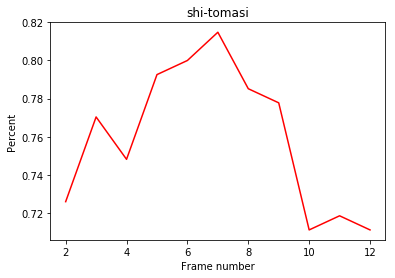

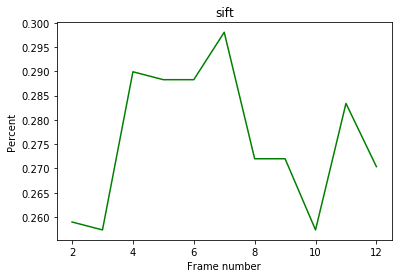

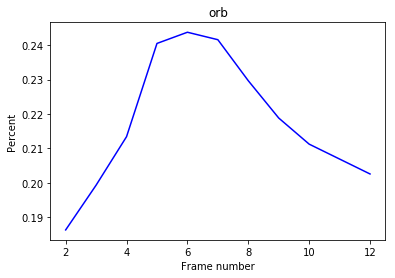

In [5]:
from matplotlib import pyplot as plt


def plot_reproducibility(xs, results, detector, style):
    plt.plot(xs, results[detector.get_name()], style)
    plt.title(detector.get_name())
    plt.xlabel('Frame number')
    plt.ylabel('Percent')
    plt.show()


xs = list(range(2, len(motion_vectors) + 2))
line_styles = ['r', 'g', 'b']
for detector, style in zip(detectors, line_styles):
    plot_reproducibility(xs, results, detector, style)